# part I


[Chorismate mutase](https://en.wikipedia.org/wiki/Chorismate_mutase) (CM) is an enzyme used by bacteria, archaea, fungi, and plants to speed up the synthesis of two amino-acids, tyrosine and phenylalanine. Given the huge increase of the reaction rate provided by CM, bacteria lacking CM can grow only if tyrosine and phenylalanine are supplemented to their growth media.

The dataset `chorismate_alignment.faa` is a Multiple Sequence Alignment (MSA) of the AroQ family of CMs, taken from [a recent paper](https://www.science.org/doi/full/10.1126/science.aba3304) (basically its Supplementary Table 1), and it has been built by *aligning* the CMs from several organisms. Aligning here means that *gaps* are added to the amino-acids of the protein sequences so that [amino-acid conserved across different organisms are vertically aligned in the MSA](https://en.wikipedia.org/wiki/Sequence_alignment).

In this tutorial, we will train several generative models with this dataset. To test the trained models, we will use two other datasets, `functional_seqs.faa` and `nonfunctional_seqs.faa` which contain some artificially generated sequences which have been shown to allow (functional sequences) or not (nonfunctional sequences) bacterial growth in *in vivo* assays.

#### Task I.1: collect training sequences
Fasta formatted files (usual extensions for these files are .fasta, or .fa, or other which contains "fa") have a standard form: they can be divided in pairs of consecutive lines, of which the first starts with the symbol '>' and then there is some free text which is the label of the first sequence, and the second line is the sequence. 
The training dataset that we will use is in fasta format, and it is technically a multiple sequence alignment, that is the sequences contained in it share the same length and have been aligned in such a way that similar parts of the sequences have the same column indexes.
The first task for this part of the tutorial is to read the training dataset and have a look at some of the sequences contained in it. 

#### Task I.2: compute conservations
Let us now give a look at some statistical properties of sequences. We can start from looking at each column of the multiple sequence alignment, and compute the conservation. 
As a first step, a good choice is to go from nucleotides to numbers, so that the list of sequences will become a rectangular matrix of integer numbers. Then, we can compute for each column $i$ the conservation $k_i$, defined as:
$$ k_i = \log_2(q) - H(f_i) = \log_2(q) + \sum_n f_i(n) \log_2(f_i(n)) ,$$
where $q$ is the number of symbols allowed in the sequence and $f_i(n)$ is the frequency of symbol $n$ in position $i$.
In what follows we will need also to represent each CM sequence as a sequence of 0s and 1s (one-hot encoding). 
Moreover, we can reduce the number of binary (one-hot) variables per site by deciding, for instance, not to encode the last amino-acid. In this way, a series of zeroes means that the site is occupied by the last amino-acid in our ordering, so we are not losing generality (actually, we are fixing a "gauge" degree of freedom).
For this task, you can decide whether to compute the conservation after one-hot encoding or before.
Once we have computed the conservation for each position, we can plot them to visually see which parts of the sequneces are more conserved in our dataset.

In [1]:
%pylab inline
from google.colab import drive
drive.mount('/content/gdrive')

Populating the interactive namespace from numpy and matplotlib
Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_fasta(file):
    "Read fasta file, returning (descriptors, sequences)."
    seqs = []
    labels = []
    with open(file, 'r') as f:
        lines = f.readlines()
        t_s = ""
        for l in lines:
            t_l = l.rstrip() # remove \n
            if t_l[0] == '>':
                if len(t_s) > 0:
                    seqs.append(t_s)   
                labels.append(t_l[1:])
                t_s = ""
            else:
                t_s = t_s + t_l
        seqs.append(t_s)    
    return labels, seqs

def seq2num(seq):
    """Transform a sequence or list of sequences
    (seq) into a list of numbers."""
    AAs = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    ntdict = {AAs[k]:k for k in range(len(AAs))}
    if type(seq) == str:
        return np.array([ntdict[x] for x in seq], dtype=np.int16)[np.newaxis,:]
    elif type(seq) == list:
        return np.array([[ntdict[x] for x in seq_] for seq_ in seq], dtype=np.int16)
    
def num2seq(num):
    "Inverse of seq2num."
    AAs = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    return ''.join([AAs[x] for x in num])
    
def seq2occurrence(seqs_AA, q_true=21):
    """Expand the alignment in an array of binary
    occurrence variables. Moreover, fix the gauge 
    by removing the last symbol."""
    seqs = seq2num(seqs_AA)
    B = seqs.shape[0]
    N = seqs.shape[1]
    q_gauge = q_true-1
    msa_exp = np.zeros((B, N * q_gauge), dtype=np.int16)
    for i in range(N):
        for a in range(q_gauge):
            msa_exp[:,i*q_gauge+a] = (seqs[:,i] == a)
    return msa_exp

def conservation_1hot(freqs, q):
    """Return the conservation, measured in bits. Freqs must be 
    a numpy array of frequencies of 1-hot encoded variables after
    gauge fixing by removing the last symbol."""
    reshaped_freqs = freqs.reshape(freqs.shape[0] // (q-1), q-1)
    lastAA_freqs = 1 - np.sum(reshaped_freqs, axis=1)
    conss = []
    for i, f in enumerate(reshaped_freqs):
        ff = f[f != 0]
        lf = lastAA_freqs[i]
        if lf != 0:
            conss.append(np.log2(q) + np.sum(ff * np.log2(ff)) + lf * np.log2(lf))
        else:
            conss.append(np.log2(q) + np.sum(ff * np.log2(ff)))
    return conss

def seq_from_1hot_gauged(seq1hot, q_true = 21):
    seq2num = []
    for i in range(len(seq1hot)//(q_true-1)):
        t_piece = seq1hot[i*(q_true-1):(i+1)*(q_true-1)]
        where = (t_piece == 1)
        if np.sum(where) == 0:
            seq2num.append(q_true-1)
        elif np.sum(where) == 1:
            seq2num.append(np.arange(q_true-1)[where][0])
        else:
            print("problem!")
    return num2seq(seq2num)



In [5]:
# load training dataset
train_labels, train_seqs = read_fasta('/content/gdrive/My Drive/TutorialCoccoComo22/data/chorismate_alignment.faa')

In [8]:
# compute frequencies, conservations
q = 21

train_occurrence = seq2occurrence(train_seqs, q_true=q)
freqs = np.sum(train_occurrence, axis=0) / train_occurrence.shape[0]
cs = conservation_1hot(freqs, q)

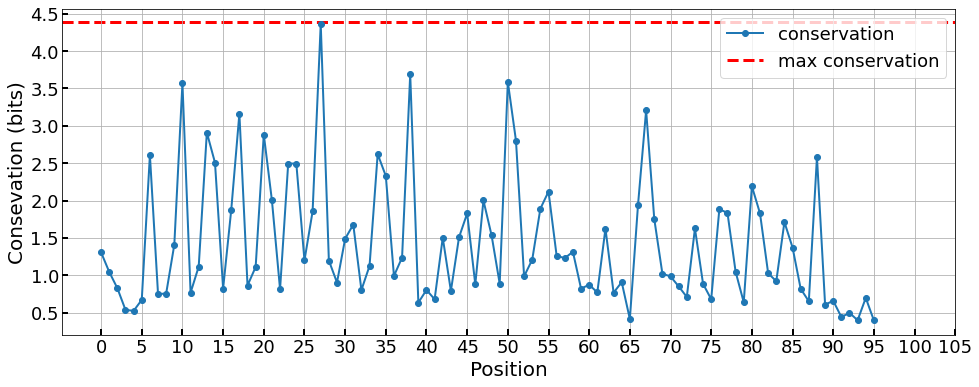

In [9]:
# plot conservations
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.plot(cs, '-o', lw=2, color="C0", label="conservation")
ax.axhline(y=np.log2(21), color='r', lw=3, ls='dashed', label="max conservation", zorder=-1)
ax.legend(fontsize=18, loc=0, framealpha=0.8)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xticks([i*5 for i in range(22)])
ax.set_xlabel("Position", fontsize=20)
ax.set_ylabel("Consevation (bits)", fontsize=20)
ax.grid()

# part II

In this part we will train the simplest possible model, an independent site model, to try to discriminate between functional and non-functional sequences. Notice that the training is completely unsupervised, as we will use the training set which is not annotated (we expect though that most of these sequences are functional).
Our model will be of the form
$$ p(s) = \frac{1}{Z} e^{-E(s)}, \quad E(s) = - \sum_{i,a} h_i(a) \, s_i(a), $$
where $p(s)$ is the probability of the sequence $s$ according to the model, $h_i$ are the "local fields", that is the parameters to be inferred, where $s_{i}(a)$ is a binary (one-hot) variable which is 1 if the symbol $a$ is present in position $i$ in the sequence $s$, 0 otherwise. $Z$ is a normalization.
This model maximizes the entropy under a set of constraints on the single-site frequences, which fix the fields so that the 1-point correlation functions of the model correspond to the frequencies observed in the data.

The partition function is
$$ Z = \prod_i \left(1 + \sum_a e^{h_i(a)} \right) $$
and the maximization of the log-likelihood of the observed data gives
$$ h_i(a) = \log(f_i(a)) - \log(f_i(g)), $$
where $g$ is the amino-acid excluded by the explicit choice of the gauge we made with the one-hot encoding (in our case, Y).

Notice, however, that there are some positions where some symbols are never observed. In principle, this would give an unrealistic minus-infinity local field, that we want to avoid. For this reason, we add a regularization in the form of a pseudo-count as follows. Consider that, to our dataset of size $M$, we add a purely random dataset of size $\alpha/(1-\alpha) M$. The new frequencies becomes:
$$ f_i(n) \to \tilde{f}_i(n) = (1-\alpha) f_i(n) + \frac{\alpha}{q}  $$

#### Task II.1: fit an independent-site model
* Find the fields of a independent-site model, and use $\alpha=0.01$ to regularize through the introduction of pseudo-counts.
* Read the test datasets, which are divided in positive (functional) and negative (non-functional) examples.
* Use the independent-site model to compute the energy of each test sequence, and check whether the independent-site model model can discriminate the functional from the non-functinoal. To do this, plot the histograms and use the AUROC as a quantification of the performance (see the `metrics` package from `sklearn`).

#### Task II.2: sample from independent-site model to check 1-pt and 2-pt correlations
The model we just fit can be used to generate new sequences. Indeed, it is enough to sample from the probability distribution that the model defines. Use the provided function to generate new sequences from this model, and check the agreement with the 1-pt and 2-pt (connected) correlations computed from the data.

In [10]:
from sklearn import metrics

In [11]:
def indip_model_fields(freqs, alpha=0, q=21):
    """Fit the independent site model in the 1-hot encoding gauge.
    Add pseudocounts, equivalent to a dataset fraction 
    alpha/(1-alpha) of random sequences added to the dataset."""
    L = len(freqs)//(q-1)
    pc_freqs = freqs * (1 - alpha) + alpha / q
    freq_gauge = np.zeros_like(pc_freqs)
    for i in range(L):
        freq_gauge[i*(q-1):(i+1)*(q-1)] = 1-np.sum(pc_freqs[i*(q-1):(i+1)*(q-1)])
    return np.log(pc_freqs/freq_gauge)

def energy_indip_model(fields, seqs):
    """Compute the energy of the sequences seqs according to the indepentend site model."""
    return -np.dot(seqs, fields)

def sample_data_indip(fields, beta=1, q=21):
    """Generate new data by sampling the independent site model."""
    L = len(fields)//(q-1)
    new_data = np.zeros_like(fields)
    for i in range(L):
        freqs = np.ones(q)
        freqs[:-1] = np.exp( beta * fields[i*(q-1):(i+1)*(q-1)] )
        freqs = freqs / freqs.sum()
        a = np.random.choice(q, p=freqs)
        if a != q-1:
            new_data[i*(q-1) + a] = 1
    return new_data

def compute_correlation_matrix(data_points):
    """Compute correlation matrix, provided that the
    data points are given as binary occurrence variables."""
    M = data_points.shape[0]
    x = data_points.astype(np.float32)
    xt = x.transpose()
    c = np.dot(xt, x) / M
    return c

def connect_correlation(corr_mat, freqs):
    """Given the correlation matrix and the frequencies,
    return the connected correlation matrix."""
    c_connected = corr_mat - np.outer(freqs, freqs)
    return c_connected

def flatten_correlation_matrix(corr, q=21):
    """Take from the correlation matrix the entries
    which do not only depend on 1-pt frequencies."""
    L = int(corr.shape[0] / (q-1))
    flatten = []
    for i in range(L):
        for a in range(q-1):
            flatten = np.r_[flatten, corr[i*(q-1)+a,(i+1)*(q-1):]]
    return flatten


In [12]:
# "train" model
ind_model_fields = indip_model_fields(freqs, alpha=0.01, q=21)

In [13]:
# load test set
_, test_seqs_pos = read_fasta("/content/gdrive/My Drive/TutorialCoccoComo22/data/functional_seqs.faa")
_, test_seqs_neg = read_fasta("/content/gdrive/My Drive/TutorialCoccoComo22/data/nonfunctional_seqs.faa")

In [14]:
# compute energies test sets
t_ss = seq2occurrence(list(test_seqs_pos))
pos_en_ind = energy_indip_model(ind_model_fields, t_ss)
t_ss = seq2occurrence(list(test_seqs_neg))
neg_en_ind = energy_indip_model(ind_model_fields, t_ss)

t_ss = seq2occurrence(list(train_seqs))
train_en_ind = energy_indip_model(ind_model_fields, t_ss)

AUROC (pos vs neg): 0.7373330452329767


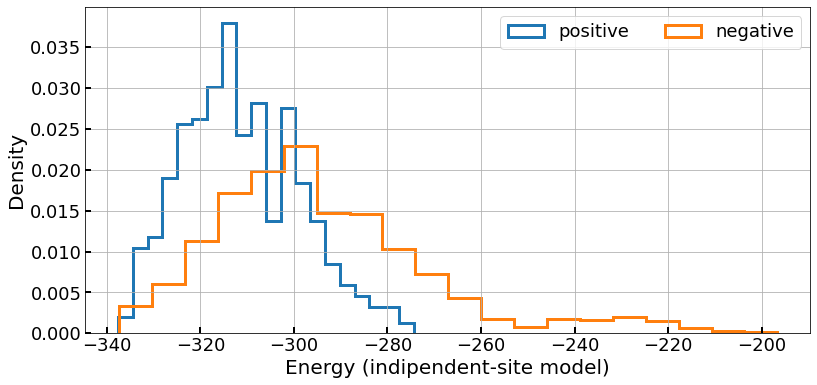

In [15]:
# plot histogram
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(pos_en_ind, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="positive")
ax.hist(neg_en_ind, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="negative")
#ax.hist(train_en_ind, histtype='step', fill=False, density=True, bins=20, lw=1, color="C2", label="training")

ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (indipendent-site model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()
# compute AUROC test set (global)
scores_positives_val = -pos_en_ind
scores_negatives_val = -neg_en_ind
labels = np.hstack((np.zeros((len(scores_negatives_val))), np.ones((len(scores_positives_val))))) 
scores = np.hstack((scores_negatives_val, scores_positives_val))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)    
auroc_global = metrics.auc(fpr, tpr)
print("AUROC (pos vs neg):", auroc_global)

In [16]:
# sample 1000 sequences from the independent site model
sample_indip = np.array([sample_data_indip(ind_model_fields, beta=1) for _ in range(1000)])

In [17]:
# compute 1-pt and 2-pt correlations
corr_train = compute_correlation_matrix(train_occurrence)
freqs_train = np.sum(train_occurrence, axis=0) / train_occurrence.shape[0]

corr_indip = compute_correlation_matrix(sample_indip)
freqs_indip = np.sum(sample_indip,axis=0) / sample_indip.shape[0]

In [18]:
# remove connected part and "diagonal" elements in 2-pt correlations
corr_train_connect = connect_correlation(corr_train,freqs_train)
corr_train_flatten = flatten_correlation_matrix(corr_train_connect)

corr_indip_connect = connect_correlation(corr_indip,freqs_indip)
corr_indip_flatten = flatten_correlation_matrix(corr_indip_connect)

R-squared value (2-pt): 0.9955244761715636
R-squared value (2-pt): 4.490035143800419e-06


Text(0.5, 1.0, '2-pt correlations')

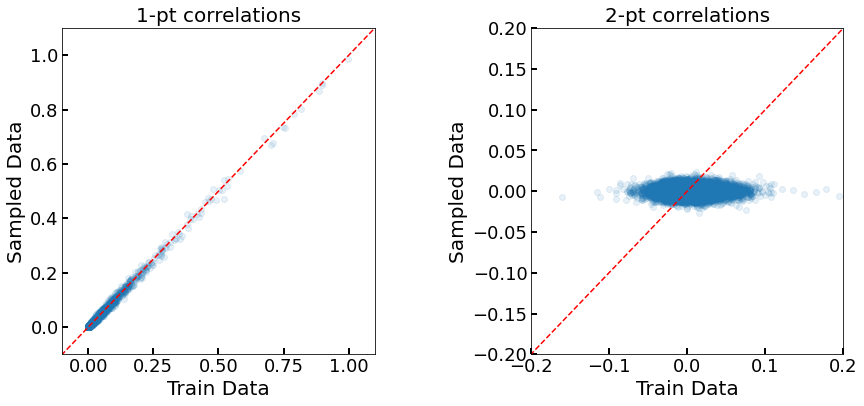

In [19]:
# plots of model vs data correlations

fig, ax = plt.subplots(figsize = (14,6), ncols=2)
fig.subplots_adjust(wspace=0.5)
ax[0].scatter(freqs_train,freqs_indip ,alpha=0.1)
ax[0].plot([-1,2],[-1,2],'r--',)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
coefs = np.polyfit(freqs_train,freqs_indip, 1)
poly1d_fn = np.poly1d(coefs) 
r2 = metrics.r2_score(freqs_indip, poly1d_fn(freqs_train))
print("R-squared value (2-pt):", r2)

ax[1].scatter(corr_train_flatten,corr_indip_flatten ,alpha=0.1)
ax[1].plot([-1,2],[-1,2],'r--',)
ax[1].set_ylim(-0.2,0.2)
ax[1].set_xlim(-0.2,0.2)
coefs = np.polyfit(corr_train_flatten,corr_indip_flatten, 1)
poly1d_fn = np.poly1d(coefs) 
r2 = metrics.r2_score(corr_indip_flatten, poly1d_fn(corr_train_flatten))
print("R-squared value (2-pt):", r2)

ax[0].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax[0].tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax[0].tick_params(axis='both', labelsize=18)
ax[0].set_xlabel('Train Data', fontsize=20)
ax[0].set_ylabel('Sampled Data', fontsize=20)
ax[0].set_title('1-pt correlations',  fontsize=20)

ax[1].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax[1].tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax[1].tick_params(axis='both', labelsize=18)
ax[1].set_xlabel('Train Data', fontsize=20)
ax[1].set_ylabel('Sampled Data', fontsize=20)
ax[1].set_title('2-pt correlations',  fontsize=20)
#ax.set_xlabel("Energy (indipendent-site model)", fontsize=20)
#ax.set_ylabel("Density", fontsize=20)

# part III

Now we turn to models able to capture 2-point correlations. We consider the model (Boltzmann Machine):
$$ p(x) = \frac{1}{Z} e^{-E(s)}, \quad E(s) = \sum_{i, a, j, b} s_{i}(a) \, J_{i,j}(a,b) \, s_{j}(b) + \sum_{i, a} \, h_i(a) s_i(a), $$
where $s_{i}(a)$ is a binary (one-hot) variable.
In this case the exact inference of the model (that is, the problem of maximizing the log-likelihood of the data) cannot be solved exactly in a reasonable amount of time. 
We will consider here the Gaussian approximation ([here](https://iopscience.iop.org/article/10.1088/1361-6633/aa9965/meta) many other approaches are described, and compared), which considers an approximation of the problem that can be solved quickly, provided that the categorical variables have zero average. To do that, we consider the new model:
$$ p(x) = \frac{1}{Z} e^{-E(\tilde{s})}, \quad E(\tilde{s}) = \sum_{i, a, j, b} \tilde{s}_{i}(a) \, J_{i,j}(a,b) \, \tilde{s}_{j}(b) + \sum_{i, a} \, h_i(a) \tilde{s}_i(a), $$
where $\tilde{s}_i(a) = s_i - f_i(a)$. Notice that, once we know how to infer the parameters for this new model, the old one can be immediately recovered by inserting the expression for the variables $\tilde{s}_i(a)$.
The Gaussian approximation consists in neglecting the binary nature of the categorical variables, and in computing the parameters $J_{i,j}(a,b)$ and $h_i(a)$ as if they were continuous variables. The relevant advantage in this case is that the normalization $Z$ can be computed exactly and derived with respect to the parameters during the maximization of the log-likelihood, and the solution is:
$$ h_i(a) = 0, \quad J_{i,j}(a,b) = - \tilde{C}^{-1}_{ia, jb}, $$
where $\tilde{C}^{-1}_{ia, jb}$ is the inverse of the correlation matrix of the (shifted) categorical variables, that is
$$ \tilde{C}_{ia, jb} = \frac{1}{M} \sum_s \tilde{s}_i(a) \tilde{s}_j(b), $$
where $M$ is the number of sequences in the training dataset and the sum spans the sequences of the training dataset. Notice that this correlation matrix can be written as
$$ \tilde{C}_{ia, jb} = \frac{1}{M} \sum_s s_i(a) s_j(b) - f_i(a) f_j(b) = C_{ia, jb} - f_i(a) f_j(b), $$
where $C_{ia, jb}$ is the correlation matrix of the original variables.

Unfortunately, the correlation matrix as it is cannot be inverted whenever the number of data is low (lower than the lenght of each the sequence in categorical variables after gauge fixing) or if the data are correlated. In this case we need again to rely on a regularization method to overcome the problem. We can again use pseudo-counts, transforming the frequences as we did for the indipendent-site model and the 2-point correlations as
$$ f_{ij}(a,b) \to \tilde{f}_{ij}(a,b) = (1-\alpha) f_{ij}(a,b) + \frac{\alpha}{q^2}, $$
where $f_{ij}(a,b)$ is the frequency of having the amino-acid $a$ in position $i$ and $b$ in position $j$.
Unfortunately, this time a little extra trick is needed to fix things up after this transformation. Indeed, this transformation has the unwanted properties that now $\tilde{f}_{ii}(a,b) \neq 0$ for $a \neq b$, and that $\tilde{f}_{ii}(a,a) \neq f_i(a)$. To get meaningful, regularized frequencies and 2-point correlations, both of these properties must be re-imposed *a posteriori* after applying the transformation.

#### Task III.1: fit a Gaussian Boltzmann Machine
* Compute the frequencies and the correlation matrix of these variables.
* Apply the transformations discussed to regularize these quantities, then take the connected correlation matrix.
* Invert the resulting matrix (you can use the function `numpy.linalg.inv` from numpy) to get the $J$ matrix of the model.
* Compute the energy of each sequence in the training set, and check whether the new model can discriminate between functional and non-functional sequences as we did for the independent-site model.

#### Task III.2: sample from Gaussian Boltzmann Machine to check 1-pt and 2-pt correlations
As for the independent-site model, the Gaussian Boltzmann Machine model define a probability distribution over the sequences, and hence can be used to generate new sequences. However, this is much more difficult due to the fact that $Z$ cannot be computed easily (when the variables are back to their binary nature), and that it is not known how to sample directly from the quadratic model (again, when the variables are binary). To overcome this problem, we can use a Metropolis routine to sample from the model. Compare the 1-pt and 2-pt correlations for the training data and those sampled with the Gaussian BM. 

In [20]:
def bm_energy(jcoupling_gauss, ave_freqs, seq):
    """Compute energy of seq with the BM model."""
    # collect local fileds
    h = np.dot(jcoupling_gauss, ave_freqs)
    ener1 = - np.dot(h, seq)
    ener2 = np.dot(seq, np.dot(jcoupling_gauss, seq)) / 2
    return -(ener1 + ener2)

def add_pseudocounts(corr_mat, freqs, alpha, q_true=21):
    """Add pseudocounts according to the 
    parameter alpha to the frequencies and the correlation matrix,
    and return them."""
    q_gauge = q_true - 1
    N = len(freqs) // q_gauge
    f_pseudo = (1-alpha)*freqs + alpha/q_true
    c_pseudo = (1-alpha)*corr_mat + alpha/(q_true**2)
    #Fix the conservation constraints in the diagonal blocks
    for i in range(N):
        c_pseudo[i*q_gauge:(i+1)*q_gauge,i*q_gauge:(i+1)*q_gauge] = 0
        for a in range(q_gauge):
            c_pseudo[i*q_gauge+a,i*q_gauge+a] = f_pseudo[i*q_gauge+a]
    return f_pseudo, c_pseudo

def metropolis(jcoupl, p, Nsteps=10000, beta=1, q_true = 21, start_conf=np.nan):
    """Handle a single chain, starting in start_conf configuration, doing Nsteps steps 
    (each step is a single, random site flip)."""
    L = len(p)
    # prepare initial config
    if np.isnan(np.sum(start_conf)):
        s = np.random.randint(1, size=L)
        start_conf = s.copy()
    else:
        if type(start_conf[0]) != np.int32:
            print('Please use starting configuration in numeric form or use None for random start.')
            return 1
        else:
            s = start_conf
    # metropolis
    for k in range(0, Nsteps):
        # propose move
        pos_t = np.random.randint(len(p)//(q_true-1))
        t_n = np.random.randint(q_true)
        t_1hot = np.repeat(0, q_true-1)
        if t_n == q_true-1:
            pass
        else:
            t_1hot[t_n] = 1
        s_t = s.copy()
        s_t[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] = t_1hot
        
        
        ## faster way to compute energy difference between configurations
        h = np.dot(jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] , p)
        delta_h = - np.dot( (s-s_t)[pos_t*(q_true-1):(pos_t+1)*(q_true-1)], h )
        jcoupl_diag = jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1),pos_t*(q_true-1):(pos_t+1)*(q_true-1)]
        jcoupl_marginal = np.dot( jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] , s)
        delta_seq = (s-s_t)[pos_t*(q_true-1):(pos_t+1)*(q_true-1)]
        delta_coupl1 = np.dot( delta_seq , jcoupl_marginal  )
        delta_coupl2 = - 0.5 * np.dot( delta_seq, np.dot(jcoupl_diag, delta_seq)  )
        energy_diff = delta_h + delta_coupl1 + delta_coupl2
        
        ## slower (but simpler to read) way to compute energy difference between configurations
        #energy_diff = bm_energy(jcoupl, p, s_t) - bm_energy(jcoupl, p, s)
        
        # accept or not
        prob = min(1, np.exp(- beta * (energy_diff)))
        x = np.random.rand()
        if x < prob:
            s = s_t.copy()
    return s

In [21]:
# compute (non connected) correlation matrix
c = compute_correlation_matrix(train_occurrence)

# add pseudocount and take connected matrix
M = train_occurrence.shape[0]
freqs = np.sum(train_occurrence, axis=0) / M
f_reg, c_reg = add_pseudocounts(c, freqs, alpha=0.01, q_true=21)
c_reg_connected = connect_correlation(c_reg, f_reg)

# compute coupling matrix
jcoupl = -np.linalg.inv(c_reg_connected)

In [22]:
# compute energies test sets
t_ss = seq2occurrence(list(test_seqs_pos), q_true=21)
pos_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

t_ss = seq2occurrence(list(test_seqs_neg), q_true=21)
neg_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

t_ss = seq2occurrence(list(train_seqs), q_true=21)
train_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

AUROC (RFAM vs generated): 0.8177917840126275


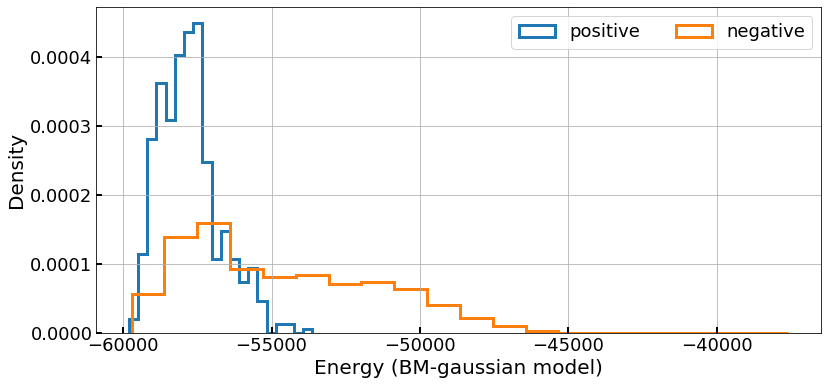

In [23]:
# plot histogram
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(pos_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="positive")
ax.hist(neg_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="negative")

#ax.hist(train_en_bm, histtype='step', fill=False, density=True, bins=20, lw=1, color="C2", label="training")
ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (BM-gaussian model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()
# compute AUROC test set (global)
scores_positives_val = -pos_en_bm
scores_negatives_val = -neg_en_bm
labels = np.hstack((np.zeros((len(scores_negatives_val))), np.ones((len(scores_positives_val))))) 
scores = np.hstack((scores_negatives_val, scores_positives_val))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)    
auroc_global = metrics.auc(fpr, tpr)
print("AUROC (RFAM vs generated):", auroc_global)

In [ ]:
# sampling from gaussian BM
t_ss = seq2occurrence(list(train_seqs), q_true=21)
sample_gaussbm = np.array([metropolis(jcoupl, f_reg, start_conf=t_ss[np.random.randint(len(t_ss))].astype('int32')) for _ in (range(100))])

In [ ]:
# visualize some sequences
seq_sample_gaussbm = [seq_from_1hot_gauged(x) for x in sample_gaussbm]
print(np.array(seq_sample_gaussbm[:10]))

['-TKPHPLSHTREQITALDNELLALLAKRRALSLDVARSKEVDIRPIRDTQREKELLARLVKQGR-EQGLDAHYVLSLYQSIIEDSVLNQQAYLQGR'
 'PAECQSMAEVRQGVDALDRALVALLAERQRYMEAAARIKPDR-DAVFDQARIDDVVAKVLTAAETHH-LAPEIAEPVWRLLIDRCIAHEFAVYDRT'
 'INNCQSLEEVRHHIDGLDDQIVELIAARNAYVKQAANFKHSV-EEIKANERMEAIMDRVRNKAMEFG-VSPNLLTKLYGIMIDAMVESEISEFRNA'
 'QKSKRDLDSFRIVIDELDENIIALFSERMNISKKLGSLKKDSDIPVYQPDRWNDIMKKSLIFGRSLG-ISEELLEGVFKLLHQESIKIQNQIR---'
 '---PTELEILRDQIDTLDSELVALLAKRAALTEQVGVYKSKVGLPIYVPAREAELIEQRCEQAKALG-VPPALVEDLLRRIMRESYHTQNKRYMCC'
 'GNPVKATASLETEIEKLDGEIVKLLNQRASATLKLLEAAPDKKAVLFDPKADDLLALKLEEKSS--GPLPAHALRGVLRQVLSSIRN-QVRTQRVA'
 '----SDIEEHRKKIEEITLEMIKLLKTRTDIAKQIGDAKASLGMTVTDEEREDALRTQVTKLCKEID-LDQSTALKFLNFLFNESVKVQSDNKQTH'
 'INKNLDLGKIREKIDKLDSQLVELLEERLHIVQEVAQFKKQTGKKIFDEEREKEVIRKNLERVKNKE--LNHYIELILKDIMDSSKEYQKFKIGV-'
 'INKILDLGEIRERIDKLDRQLVELLEERLYIVQEVAQFKKNTGKKIFDEEREKEVVEKNLERVKNKE--LNHYIELILKDIMNSSKEYQKFKIGI-'
 '----ATLEELRVELDKIDNQMVELYQKRMNVCREVGDYKVKAGRKVYDRQREQEKLADVASKVDND--FDKNGVRELYTQLMSMSRKLQYQKLVEA']

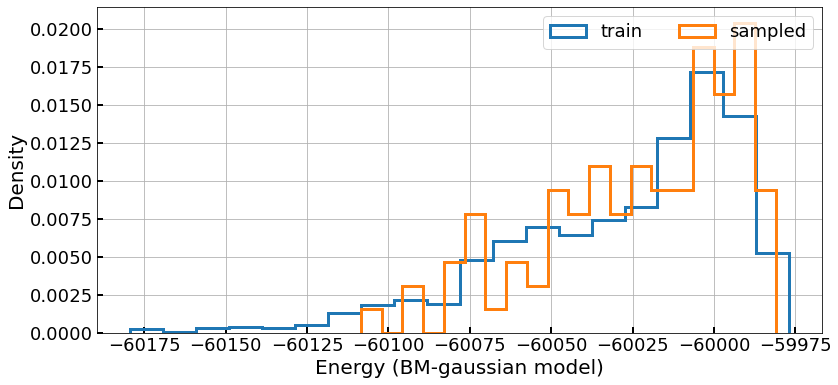

In [ ]:
# test sampling by comparing with the training data
sample_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in sample_gaussbm])

fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(train_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="train")
ax.hist(sample_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="sampled")

ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (BM-gaussian model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()

In [ ]:
# compute 1-pt and 2-pt correlations of the sampled data
corr_sample = compute_correlation_matrix(sample_gaussbm)
freqs_sample = np.sum(sample_gaussbm, axis=0) / sample_gaussbm.shape[0]
corr_sample_connect = connect_correlation(corr_sample,freqs_sample)
corr_sample_flatten = flatten_correlation_matrix(corr_sample_connect)

R-squared value (1-pt): 0.9586383244568728
R-squared value (2-pt): 0.4214664879889547


Text(0.5, 1.0, '2-pt correlations')

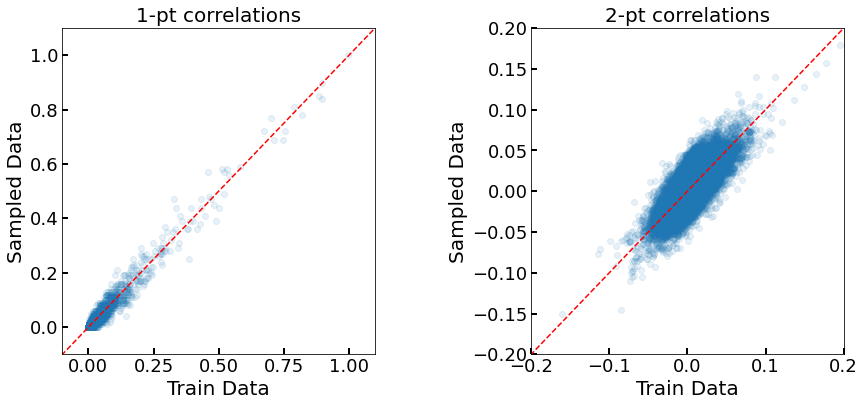

In [ ]:
# plots of model vs data correlations

fig, ax = plt.subplots(figsize = (14,6), ncols=2)
fig.subplots_adjust(wspace=0.5)
ax[0].scatter(freqs_train,freqs_sample ,alpha=0.1)
ax[0].plot([-1,2],[-1,2],'r--',)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(-0.1,1.1)
coefs = np.polyfit(freqs_train,freqs_sample, 1)
poly1d_fn = np.poly1d(coefs) 
r2 = metrics.r2_score(freqs_sample, poly1d_fn(freqs_train))
print("R-squared value (1-pt):", r2)

ax[1].scatter(corr_train_flatten,corr_sample_flatten ,alpha=0.1)
ax[1].plot([-1,2],[-1,2],'r--',)
ax[1].set_ylim(-0.2,0.2)
ax[1].set_xlim(-0.2,0.2)
coefs = np.polyfit(corr_train_flatten,corr_sample_flatten, 1)
poly1d_fn = np.poly1d(coefs) 
r2 = metrics.r2_score(corr_sample_flatten, poly1d_fn(corr_train_flatten))
print("R-squared value (2-pt):", r2)

ax[0].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax[0].tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax[0].tick_params(axis='both', labelsize=18)
ax[0].set_xlabel('Train Data', fontsize=20)
ax[0].set_ylabel('Sampled Data', fontsize=20)
ax[0].set_title('1-pt correlations',  fontsize=20)

ax[1].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax[1].tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax[1].tick_params(axis='both', labelsize=18)
ax[1].set_xlabel('Train Data', fontsize=20)
ax[1].set_ylabel('Sampled Data', fontsize=20)
ax[1].set_title('2-pt correlations',  fontsize=20)
#ax.set_xlabel("Energy (indipendent-site model)", fontsize=20)
#ax.set_ylabel("Density", fontsize=20)